In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 
import glob

import tqdm

from nd2reader import ND2Reader
import h5py
import pickle
import json

import datetime

import warnings
warnings.filterwarnin
s('ignore')

import ffmpeg

from skimage.filters 
mport rank, threshold_otsu, threshold_local#
from skimage import m
rphology

import scipy 
import skimage

import pandas as pd
import seaborn as sns
import csv

from tools.func import *

In [2]:
#Draw rectangle to images
def mousePoints(event,x,y,flags,param):
    #Crop image
    global refPt
    global img
    global final_boundaries
    global stopper
    # Left button click
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        refPt.append((x, y))
        final_boundaries.append((refPt[0],refPt[1]))
        stopper = True
        cv2.imshow("win", img)
        print("two clicks!")
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        clone = img.copy()
        cv2.rectangle(clone, refPt[0], (x, y), (0, 255, 0), 4)
        cv2.imshow("win", clone)



def parse_raw_dict(day, video_path, own_meta):

    fh = video_path

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    label_map = None

    if isinstance(fh, str):
        if not fh.endswith(".nd2"):
            raise InvalidFileType(
                ("The file %s you want to read with nd2reader" % fh)
                + " does not have extension .nd2."
            )
        
        filename = fh

        fh = open(fh, "rb")

    _fh = fh
    _fh.seek(-8, 2)
    chunk_map_start_location = struct.unpack("Q", _fh.read(8))[0]
    _fh.seek(chunk_map_start_location)
    raw_text = _fh.read(-1)
    label_map = LabelMap(raw_text)
    datasTT = RawMetadata(_fh, label_map)


    seeding_density = []
    well_name = []
    well_info = datasTT.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'uLoopPars'][b'Points'][b'']
    for i in range(len(well_info)):
        
        label = (well_info[i][b'dPosName']).decode("utf8")
        lable_parts = label.split("_")
        if len(lable_parts) == 1:
            seeding_density.append(500)
        else:
            try:
                seeding_density.append(int(lable_parts[1]))
            except:
                seeding_density.append(500)
                print(lable_parts[1])

        well_name.append(lable_parts[0])

    own_meta[day]["cell"] = well_name
    own_meta[day]["seeding_density"] = seeding_density
    own_meta[day]["dt"] = datasTT.image_metadata[b'SLxExperiment'][b'uLoopPars'][b'dPeriod']*1e-3

    return own_meta
        

In [9]:
root_path = "D:/instru_projects/TimeLapses/u-wells/*"
target_paths = glob.glob(os.path.join(root_path, "*.nd2"))

root_path_2 = "E:/instru_projects/TimeLapses/u-wells/*"
target_paths = target_paths + glob.glob(os.path.join(root_path_2, "*.nd2"))

root_path_FL = "E:/instru_projects/TimeLapses/u-wells/*"
target_paths_FL = glob.glob(os.path.join(root_path_FL, "*_spheroidCulturemCherry.nd2"))



In [10]:
print("Target paths:\n", target_paths, "\nFL paths:\n", target_paths_FL)

Target paths:
 ['D:/instru_projects/TimeLapses/u-wells\\collagen\\240226_timelapses_collagen_3lines_72h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240301_timelapses_collagen_3lines_48h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240302_timelapses_collagen_3lines_110h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240304_timelapses_collagen_3lines_48h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240305_timelapses_collagen_3lines_91h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240311_timelapses_collagen_3lines_96h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\collagen\\240312_timelapses_collagen_3lines_111h_spheroidseeded.nd2', 'D:/instru_projects/TimeLapses/u-wells\\IPN\\230417_timelapses_IPN3mM_3lines_63h_culture.nd2', 'D:/instru_projects/TimeLapses/u-wells\\IPN\\230418_timelapses_IPN3mM_3lines_91h_culture.nd2', 'E:/instru_projects/TimeLapse

In [6]:
with open('./dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

coord_dict = {}

skip_existing = True
map_coord = True

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    matrix = parts[2]
    n_ines = parts[3][0]
    start_time = int(parts[4][:-1])
    comments = parts[5][:-3]

    if day not in own_meta.keys():
        own_meta[day] = {}
    elif skip_existing:
        continue

    own_meta[day]["matrix"]  = matrix
    own_meta[day]["n_cells"]  = n_ines
    own_meta[day]["dim"] = "3D"
    own_meta[day]["incubation_time"] = start_time
    own_meta[day]["other"] = "other"

    own_meta = parse_raw_dict(day, video_path, own_meta)
    
    if map_coord:

        with ND2Reader(video_path) as images:

            coords = []
            final_boundaries = []
            metas = load_metadata(images)
            z_levels = metas["n_levels"]
            vis_level = int(z_levels/2)
            stopper = False

            for i in range(metas["n_fields"]):

                cv2.namedWindow('win',cv2.WINDOW_NORMAL)
                cv2.setMouseCallback("win", mousePoints)

                if metas["n_channels"] == 2:
                    img = images.get_frame_2D(c=1, t=0, z=vis_level, x=0, y=0, v=i)
                else:
                    img = images.get_frame_2D(c=0, t=0, z=vis_level, x=0, y=0, v=i)
                    
                cv2.imshow("win",img)

                k = cv2.waitKey(0)

                if k == ord("q"):  # Press q to quit
                    break

                if stopper == True:

                    stopper = False
                    coords.append(final_boundaries)
                    final_boundaries = []
                    cv2.destroyAllWindows()


            cv2.destroyAllWindows()

            if k == ord("q"):  # Press q to quit
                break

        final_coords = []

        for i in range(len(coords)):
            final_coords.append([[coords[i][0][0][0], coords[i][0][0][1]], [coords[i][0][1][0], coords[i][0][1][1]]])

        
        own_meta[day]["coords"] = final_coords
        
        if k == ord("q"):  # Press q to quit
            break


    with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
        json.dump(own_meta, f, ensure_ascii=False, indent=4)


In [8]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    own_meta = parse_raw_dict(day, video_path, own_meta)

    with ND2Reader(video_path) as images:
        metas = load_metadata(images)

    for k in metas.keys():
        own_meta[day][k] = metas[k]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)


In [10]:
print(video_path, t_id, loc_id)

D:/instru_projects/TimeLapses/u-wells\IPN\230418_timelapses_IPN3mM_3lines_91h_culture.nd2 65 1


In [15]:
target_paths[9:]

['E:/instru_projects/TimeLapses/u-wells\\collagen\\240307_timelapses_collagen_3lines_72h_spheroidseeded.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\230417_timelapses_IPN3mM_3lines_63h_culture.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\240426_timelapses_IPN3mM_3lines_48h_spheroid15hculture005.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\240502_timelapses_IPN40mM_3lines_48h_spheroidculture001.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\240519_timelapses_IPN3mM_3lines_48h_spheroidCulturemCherry.nd2']

In [16]:
with open('./dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

scaler = 350


for video_path in tqdm.tqdm(target_paths[9:], total=len(target_paths[9:])):
    if video_path in target_paths_FL:
        continue

    video_name = os.path.split(video_path)[-1][:-4]
    root_path = os.path.split(video_path)[0]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    coords = own_meta[day]["coords"]

    loc_id = 0
    t_id = 0
    channel = "BF"
    track_list = []
    total_dict = {}

    out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
    out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 0, (2304,2304))
    #out_process = ( 
    #ffmpeg 
    #.input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
    #.format(2304, 2304)) 
    #.output(out_name, pix_fmt='yuv420p') .overwrite_output() 
    #.run_async(pipe_stdin=True) 
    #)

    with ND2Reader(video_path) as images:
        #c -channel, v - locations, t - time
        
        metas = load_metadata(images)
        images.iter_axes = "vt"
        images.bundle_axes = "zyx"

        area_th = int(40/metas["m"])**2*np.pi
        vis_level = int(metas["n_levels"]/2)
        frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))
        x_final = coords[loc_id][0] #(0,2304)
        y_final = coords[loc_id][1] #(2304,0) 


        for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):

            c_id = idx%metas["n_channels"]
            id_name = metas["channels"][c_id]


            if (id_name != channel) : #| (loc_id != 1)
                #t_id += 1
                #if t_id == metas["n_frames"]:
                #    t_id = 0
                #    loc_id += 1
                continue

            projected_frame =  np.min(img, axis = 0)
            th = np.percentile(projected_frame.flatten(),5)
            projected_frame[projected_frame>th] = 0
            
            x, y, r, area, x_start, y_start, mask = process_frame(projected_frame, x_final, y_final)

            if area < area_th:
                print("No object found")
            else:
                x_final = x_start
                y_final = y_start

            focus_level = - np.inf
            focus_idx = 0

            for i in range(img.shape[0]):

                current_frame = img[i].copy()
                cropped = current_frame[x_final[1]:y_final[1], x_final[0]:y_final[0]]
                
                if (cropped.shape[0] == 0) or (cropped.shape[1] == 0):
                    lap = - np.inf
                else:
                    lap = cv2.Laplacian(cropped, cv2.CV_64F).var()

                if focus_level < lap:

                    focus_level = lap
                    focus_idx = i
                    print(focus_idx)

            int_frame = (img[focus_idx]*2**8/(2**16)).astype("uint8")
            int_frame = np.stack((int_frame,int_frame,int_frame), axis = -1)
            img_normalized = cv2.normalize(int_frame, None, 0, 255, cv2.NORM_MINMAX)
            img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
            cv2.rectangle(img_normalized, x_start, y_start, (2**16,0,0), 5)
            int_mask = (mask.astype(bool)*255).astype("uint8")
            int_mask = np.stack((int_mask,int_mask,int_mask), axis = -1)
            out_vis = cv2.addWeighted(img_normalized,1.0,int_mask,0.75,0)

            #plt.imshow(out_vis)
            #plt.show()

            #out_process.stdin.write(out_vis)
            out_process.write(out_vis)
                
            track_list.append([x*metas["m"], y*metas["m"], r*metas["m"], area*metas["m"]**2, (focus_idx-1)*metas["z_step"], mask])
            t_id += 1

            if t_id == metas["n_frames"]:

                total_dict = pile_data(track_list, total_dict, loc_id, channel)

                #out_process.stdin.close()
                #out_process.wait()
                out_process.release()

                with open(os.path.join(results,'{}_detections.pkl'.format(os.path.split(video_path)[1][:-4])), 'wb') as f:
                    pickle.dump(total_dict, f)

                t_id = 0
                loc_id += 1
                track_list = []

                if loc_id == metas["n_fields"]:
                    break
                
                x_final = coords[loc_id][0] #(0,2304)
                y_final = coords[loc_id][1] #(2304,0) 

                #if loc_id == 2:
                #    break
                
                out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
                out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 10, (2304,2304))
                #out_process = ( 
                #ffmpeg 
                #.input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
                #.format(2304, 2304)) 
                #.output(out_name, pix_fmt='yuv420p') .overwrite_output() 
                #.run_async(pipe_stdin=True) 
                #)

    #out_process.stdin.close()
    #out_process.wait()
    out_process.release()


  0%|          | 0/5 [00:00<?, ?it/s]

0
4
5
6
8
9
10
11


0
2
5
6
8
9
10
11


0
2
4
9
10


0


0
10
11


0
1
3
4
5
8
10
11


0
3
4
5
10
11
12


0
1
3
4
11
12


0
3
4
5
11
12
13


0
4
11
12
13


0
1
2
3
4
5
11
12
13


0
3
5
12
13


0
4
5
12
13


0
5
6
13
14


0
3
4
5
13
14


0
4
5
13
14


0
4
5
12
13
14


0
1
4
5
13
14


0
5
6
13
15


0
4
5
7
14


0
4
5
6


0
2
4
5
6
14


0
4
5
15


0
3
4
5
6
13
14


0
4
5
6
14
15


0
4
5
7
14


0
4
5
13
14


0
1
5
6
13
14
15


0
13
14


0


0


0


0


0


0


0


0


0
1
4


0


0
1
4


0


0
5


0
4


0


0


0
4
5


0
1


0
14


0
15


0
14
15


0
15


0
1
14


0
13
14
15


0
14
15


0
2
14
15


0
5
15


0
5
13
14


0
3
4
5


0
1
2
3
4
5
13
14


0
1
2
3
4
5
6
12
13
14


0
7
13


0
2
4
8
11
12
13
14


0
4
8
13
14


0
4
11
12
14


0
5
12
13


0
4
12
13
14


0
4
12
13
14


0
11
13
14


0
12
13


0
1
13


0
3
4
12


0


0
13


0
1


0


0


0
2


0


0


0
1


0


0
2


0
1


0


0


0
1


0


0
1


0


0


0


0
1


0


0
1


0


0
8
9
10
11
12
13


0
9
10
11
12
13


0
2
4
5
6
8
9
10
11
12
13


0
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
4
6
8
9
10
11
12
13


0
4
8
9
10
11
12
13


0
8
9
10
11
12
13


0
9
10
11
12
13


0
9
10
11
12
13


0
1
9
10
11
12
13


0
8
9
10
11
12
13


0
8
9
10
11
12
13


0
1
6
7
8
9
10
11
12
13


0
7
8
9
10
12
13
14


0
8
9
10
12
13
14


0
7
8
9
10
13
14
15


0
1
5
7
8
9
10
12
13
14


0
1
5
7
8
9
13
14


0
4
7
8
9
10
13
14


0
1
7
8
9
13
14


0
2
6
7
8
9
10
13
14


0
3
7
8
9
13
14


0
7
8
13
14


0
6
7
8
9
10
13
14


0
1
2
6
7
13
14
15


0
5
6
7
8
9
14
15


0
3
4
7
8
9
14
15


0
5
6
7
8
9
15
16


0
2
5
6
7
8
9
16


0
1
6
7
8
9
10
14
15
16


0
1
5
7
8
9
10
15
16


0
6
7
8
9
10
15
16


0
8
9
10
15
16


0
8
9
10
15
16


0
9
10
15
16


0
9
10
11
12
15
16


0
14
15
16


0
1
15
16
17


0
15
16
17


0
10
13
14
15
16
17


0
10
15
16
17


0
1
10
15
16
17


0
10
16
17


0
16
17


0
16
17


0
1


0
1


0


0


0
1
2
4
16
18


0
1
15
16


0
8
9


0
8
9
10


0
2
10


0
8
10
11


0
1
3
4
9
10
15
16


0
4
5
8
9
10
14
15


0
1
4
6
7
8
9
10


0
1
6
7
8
9
10


0
6
7
8
9
10
15


0
2
4
6
7
8
9
10
16


0
2
8
9
10
15
16


0
1
2
5
8
9
10
11
14
15
16


0
4
6
7
8
9
10
11
12
14
15


0
4
8
9
11
12
14
15


0
2
3
5
6
8
9
10
15
16


0
1
2
5
7
8
9
10
15
16
17


0
3
7
8
9
10
15
16
17


0
1
4
9
10
11
15
16
17


0
3
9
10
15
16
17


0
8
9
10
14
15
16
17


0
8
9
10
14
15
16
17


0
3
4
7
8
9
10
11
14
15
16
17


0
9
10
14
15
16
17


0
7
8
10
15
16
17


0
1
9
10
15
16
17


0
1
5
8
9
11
15
16
17


0
8
9
15
16
17


0
1
8
9
10
11
15
16
17


0
1
2
7
8
11
15
16
17


0
2
4
7
8
9
10
11
15
16
17


0
1
3
6
8
10
15
16


0
1
2
5
8
9
10
15
16
17


0
2
9
10
11
14
15
16


0
3
4
7
8
9
10
15
16


0
2
5
6
7
8
9
10
14
15
16


0
1
2
4
5
7
9
10
14
15
16


0
1
3
4
5
8
9
10
11
15
16


0
1
3
4
9
10
15
16


0
1
4
5
8
9
10
11
14
15
16


0
3
4
7
8
9
10
11
14
15
16


0
1
5
8
9
10
15
16
17


0
1
5
7
8
9
10
11
15
16


0
3
8
9
10
11
14
15
16
17


0
1
2
3
4
5
6
7
10
11


0
2
3
4
5
6
7
9
10
11


0
1
2
3
4
5
6
7
8
9
10
11


0
1
2
3
4
5
6
7
8
9
10
11


0
2
3
4
5
6
7
8
9
10
11


0
4
5
6
7
8
10
11
12


0
4
5
6
7
8
11
12


0
5
6
7
8
11
12


0
6
7
8
9
11
12
13


0
1
7
8
9
10
11
12
13


0
8
9
10
11
12
13


0
1
8
9
10
11
12
13
14


0
8
9
10
11
13
14


0
1
8
9
10
11
13
14


0
1
7
8
9
10
11
12
13
14


0
1
8
9
10
11
12
13
14
15


0
1
8
9
10
11
12
13
14
15


0
8
9
10
11
12
13
14
15


0
2
8
9
10
11
12
13
14
15


0
2
8
9
10
11
12
13
14
15


0
1
8
9
10
11
12
13
14
15


0
8
9
10
11
12
13
14
15
16


0
1
3
9
10
11
12
13
14
15
16


0
1
9
10
11
12
13
14
15
16


0
1
2
9
10
11
12
13
14
15
16


0
1
9
10
11
12
13
14
15
16


0
1
9
10
11
12
13
14
15
16


0
1
9
10
11
12
13
14
15
16


0
10
11
12
13
14
15
16


0
9
10
11
12
13
14
15
16


0
9
10
11
12
13
14
15
16


0
2
10
11
12
13
14
15
16


0
1
2
10
11
12
13
14
15
16
17


0
1
10
11
12
13
14
15
16
17


0
1
2
10
11
12
13
14
16
17


0
1
10
11
12
13
14
16
17


0
1
3
10
11
12
13
14
16
17


0
1
2
11
12
13
14
15
16
17


0
1
2
11
12
13
14
15
16
17
18


0
11
12
13
14
15
16
17
18


0
1
2
12
13
14
15
16
17
18


0
1
2
12
13
14
15
16
17
18
19


0
1
12
13
14
15
16
17
18
19


0
1
12
13
14
15
16
17
18


0
1
13
14
15
16
17
18


0
1
2
12
13
14
15
16
17
18


0
12
13
14
15
16
17
18


0
13
14
15
16
17
18


0
1
13
14
15
16
17
18


0
1
13
14
15
16
17
18
19


0
1
13
14
15
16
17
18
19


0
13
14
15
16
17
18
19
20


0
2
14
15
16
17
18
19
20


0
15
16
17
18
19
20


0
15
16
17
18
19
20


0
15
16
17
18
19
20


0
16
17
18
19


20
0
16
17
18
19
20


0
17
18
19
20


0
17
18
19
20


0
17
18
19
20


0
17
18
19
20


0
17
18
19
20


0
18
19
20


0
18
19
20


0
18
19
20


0
18
19
20


0
1
19
20


0
19
20


0
19
20


0
19
20


0
19
20


0
19
20


0
20


0
1
20


0
1
20


0
1
20


0
1
2


20
0
1
20


0
1
20


0
1
2
19
20


0
1
19
20


0
1
20


0
1
2
19
20


0
1
2
19


20
0
1
2
19
20


0
1
2
19
20


0
1
19
20


0
1
20


0
1
2
19
20


0
1
2
18
19
20


0
1
2
19
20


0
1
2
19
20


0
1
19


20
0
1
19
20


0
6
7
8
9
13


0
1
6
7
8
9
10
11


0
1
6
7
8
9
10
11
12


0
5
6
7
8
9
10
11
12


0
1
5
6
7
8
9
11
12


0
6
7
8
9
11
12


0
6
7
8
9
10
11
12


0
7
8
9
10
11


0
7
8
9
10
11
12


0
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
8
9
10
11
12


0
8
9
10
11


0
8
9
10
11
12


0
8
9
10
11


0
8
9
10
11


0
7
8
9
10
11


0
1
7
8
9
10
11


0
2
7
8
9
10
11


0
1
2
5
6
7
8
9
10
11


0
3
5
7
8
9
10
11


0
5
7
8
9
10
11


0
1
7
8
9
10
11


0
2
4
7
8
9
10
11


0
1
7
8
9
10
11


0
1
2
7
8
9
10
11


0
7
8
9
10
11


0
7
8
9
10
11


0
7
8
9
10
11


0
4
7
8
9
10
11


0
2
7
8
9
10
11


0
4
8
9
10
11
12


0
1
8
9
10
11
12


0
1
2
8
9
10
11
12


0
1
2
4
8
9
10
11
12


0
2
8
9
10
11
12


0
8
9
10
11
12


0
2
8
9
10
11
12


0
3
4
8
9
10
11
12


0
2
8
9
10
11
12


0
1
3
5
8
9
10
11
12


0
2
3
4
5
8
9
10
11
12


0
1
2
3
4
5
7
8
9
10
11
12


0
1
2
3
4
8
9
10
11
12


0
2
4
5
7
8
9
10
11
12
13


0
1
2
4
5
7
8
9
10
11
12
13


0
1
3
4
5
7
8
9
10
11
12
13


0
1
4
7
8
9
10
11
12
13


0
7
8
9
10
11
12


0
3
7
8
9
10
11
12
13


0
8
9
10
11
12


0
9
10
11
12


0
9
10
11
12


0
10
11
12
13


0
10
11
12


0
10
11
12


0
10
11
12
13


0
11
12
13


0
11
12


0
11
12
13


0
11


0
11
13


0
11
12


0
11
12


0
11


0
11


0
11


0
1
11
12


0
11


0
11


0
11


0
11
12


0
11
12


0
11
12


0
2
11
12


0
2
11
12


0
10
11
12


0
10
11
12
13


0
1
10
11
12


0
2
9
10
11
12


0
1
9
10
11
12


0
9
10
11
12


0
2
3
9
10
11
12


0
1
9
10
11
12


0
9
10
11
12


0
1
9
10
11
12


0
1
9
10
11
12


0
1
2
9
10
11
12
13


0
10
11
12
13
14


0
3
9
10
11
12
13
14


0
1
9
10
11
12
13
14


0
9
10
11
12
13


0
9
10
11
12
13
14


0
2
3
9
10
11
12
13


0
6
7
8
9


No object found
0
1
2
6


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0
8
9
10
11


No object found
0
1
3
4
6
10


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
2


No object found
0


No object found
0
1
2
13
16


No object found
0
1
4
9
10
11


No object found
0
1
5
8
10


No object found
0
1
6
7
9


No object found
0
1
6
7


No object found
0
1
2


No object found
0
1
2


No object found
0
6


No object found
0
2


No object found
0
1
2


No object found
0
1


No object found
0
1
2


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
1


No object found
0
1
2


No object found
0
1
2


No object found
0
1


No object found
0
1


No object found
0


No object found
0
1
2


No object found
0
1


No object found
0
20


No object found
0
20


No object found
0
1
20


No object found
0
1
20


No object found
0
1
2
19
20


No object found
0
1
18
19
20


No object found
0
1
18
19
20


No object found
0
1
2
17
19
20


No object found
0
1
17
18
19
20


No object found
0
1
18
19
20


No object found
0
17
18
19
20


No object found
0
17
18
20


No object found
0
1
17
18
19
20


No object found
0
2
17
18
19
20


No object found
0
1
15
17
18
19
20


No object found
0
14
16
17
19
20


No object found
0
14
16
18
19
20


No object found
0
1
17
18
19
20


No object found
0
14
15
16
17
18
19
20


No object found
0
1
2
14
15
16
18
19


No object found
0
1
13
14
17
20


No object found
0
1
13
14
20


No object found
0
13
17
19
20


No object found
0
13
14
16
18
19


No object found
0
1
13
14
16
17
18


No object found
0
13
17
18
19
20


No object found
0
1
13
14
16
18
19
20


No object found
0
13
16
17
19
20


No object found
0
1
12
13
14
15
17
18
19
20


No object found
0
1
2
12
13
19


No object found
0
1
2
12
13
14
19
20


No object found
0
2
12
13
14
17
19


No object found
0
12
13
18
20


No object found
0
1
12
13


No object found
0
1
2
12
13
16
19


No object found
0
2
12
13


No object found
0
11
12


No object found
0
1
11
12


No object found
0
11
12


No object found
0
1
11
12
15


No object found
0
1
11
12


No object found
0
1
2
11
12


No object found
0
1
2
12


No object found
0
1
11
12


No object found
0
1
11
12
19


No object found
0
1
11
12
13


No object found
0
1
2
11
12


No object found
0
1
2
11
12


No object found
0
1
2
7
8
11
12


No object found
0
1
2
4
5
6
11
12


No object found
0
1
5
7
8
10
11


0
2
3
4
6
7
8
10
11
12


0
3
4
6
7
8
10
11


0
1
3
6
7
10
11


0
2
6
7
10
11


0
7
10
11


0
7
10
11


0
7
9
10
11


0
2
3
6
7
9
10
11


0
6
7
9
10
11


0
6
7
9
10
11


0
6
7
9
10


0
6
7
9
10


0
1
2
6
7
8
9
10


0
6
7
9
10


0
1
5
6
7
8
9
10


0
5
6
7
8
9
10


0
6
7
8
9
10


0
5
6
7
9
10


0
5
6
7
8
9
10


0
5
6
8
9
10


0
5
6
8
9
10


0
5
6
8
9


0
1
5
6
7
8
9


0
5
6
7
8
9


0
5
6
7
8
9


0
1
5
6
7
8
9


0
6
7
8
9


0
5
6
8
9


0
1
5
6
8
9


0
5
6
8
9
10


0
5
6
8
9
10


0
3
5
6
8
9
10


0
6
7
9
10


0
2
6
7
9
10


0
1
6
8
9
10


0
1
3
6
7
9
10
11


0
1
3
6
7
9
10
11


0
2
6
7
8
9
10
11


0
1
2
6
7
9
10
11


0
1
3
4
5
6
7
8
9
10
11


0
1
3
6
7
8
9
10
11


0
1
2
3
6
7
8
9
10
11


0
2
3
6
7
9
10
11


0
1
3
6
7
8
9
10
11


0
2
3
6
7
8
9
10
11


0
2
3
5
6
7
9
10
11


0
2
3
6
7
8
9
10
11


0
1
3
5
6
7
9
10
11


0
1
3
6
7
9
10


0
2
3
5
6
7
9
10
11


0
3
4
5
6
7
8
9
10
11


0
1
2
3
6
7
8
9
10
11


0
2
3
6
7
9
10


0
1
6
7
9
10
11


0
3
6
7
8
9
10
11


0
3
6
7
9
10
11


0
2
3
6
7
8
9
10
11


0
3
6
7
8
9
10
11


0
1
2
3
6
7
9
10
11


0
1
3
6
7
8
9
10
11


0
1
3
6
7
9
10
11


0
2
3
6
7
8
9
10
11


0
2
3
6
7
8
9
10
11


0
1
3
6
7
8
9
10
11


0
1
6
7
8
9
10


0
3
6
7
8
9
10
11


0
3
6
7
8
9
10
11


0
1
3
6
7
9
10
11


0
3
6
7
8
9
10
11


0
2
3
6
7
8
9
10
11


0
6
7
9
10


0
2
3
6
7
8
9
10
11


0
3
6
7
8
9
10
11


0
1
2
3
5
6
7
8
9
10
11


0
1
3
6
7
8
10
11


0
3
5
6
7
8
9
11


0
1
2
3
5
6
7
11


0
2
3
5
6
7
8
11


0
5
6
7
8


0
3
4
5
6
7
8
11


0
1
2
3
4
5
6
7
8
11


0
1
3
5
6
7
8
11


0
3
5
6
7
8


0
1
4
5
6
7
11


0
2
3
5
6
7
8
11


0
3
5
6
8
9
11


0
1
3
5
6
7


0
1
3
5
6
7
8
11


0
3
5
6
7
8
10
11


0
1
2
5
6
7
11


0
1
3
5
6
7
8
11


0
2
3
5
6
7
11


0
2
5
6
7
11


0
5
6
7


0
1
4
5
6
7
8


0
2
3
5
6
7
10
11
12


0
1
3
5
6
7
9
10
11
12


0
1
2
3
5
6
7
9
10
11
12


0
2
5
6
7
8
9
10
11
12


0
1
2
5
6
7
8
9
10
11
12


0
1
4
5
6
7
8
9
10
11
12


0
1
2
4
5
6
8
9
10
11
12


0
1
3
4
5
8
9
10
11
12
13


0
3
4
10
11
12
13
14
15


0
3
4
12
13
14
15
16


0
3
4
12
13
14
15
16
17


0
2
4
13
14
15


16
17
0
4
14
15


16
17
No object found
0
3
4
15
16


17
18
No object found
0
4
16


17
18
No object found
0
1


17
18
19
No object found
0
4


18
19
20
No object found
0
1
4


19
20
No object found
0
4


20
No object found
0
4


20
0
1
2
3
4


0


0


0


0


0


0


0


0


0


0
1


0


0


0
3


0


0
3


0
1
2
3


0
3


0
2
3


0
2


0


0


0
1
3


0
1


0


0


0


0


0
1
3


0
3


0


0
1
3
4


0
3
4


0
1
3


0


0


0
4


0
1


0
1
3


0


0
3


0


0


0
1
4


0
1


0


0
1
3


0
3
4


0


0
3


0


0
4


0
3


0
1
2
3


0


0


0


0
3


0


0


0
2


0


0


0
1


0


0


0


0


0


0


0


0


No object found
0


0
1


No object found
0


0
1
2
3
7
8
9


0
1
2
3
5
7
8
9


0
1
3
4
6
8


0
1
3
4
5
6


0
1
4
5
6
7


0
1
5
6
7


0
1
5
6
7
8


0
1
6
7
8


0
1
7
8
9


0
1
8
9
10


0
1
9
10
11


0
1
10
11
12


0
1
10
11
12


0
1
11
12
13


0
1
12
13
14


0
13
14
15


0
1
14
15
16


0
1


15
16
17
0
1


16
17
18
0
1


17
18
19
0
1


18
19
20
0
1


19
20
0
1


20
0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1


0
1


0
1


0


0


0


0


0


0


0
1


0


0


0


0


0
1


0
1


0


0
1


0


0
1


0


0
1


0
1


0
1


0


0
1


0


0


0
1


0


0


0


0
1


0


0
1


0
1


0


0


0
1


0


0
1


0


0
1


0
1


0
1


0
1


0
1


0


0
1


0
1


0
1


0


0
1
2
3
5
6
7
10
11
12


0
5
6
7
10
11
12


0
2
3
5
6
7
9
10
11
12


0
1
2
5
6
7
9
10
11
12


0
1
2
3
5
6
7
9
10
11
12


0
1
2
5
6
7
8
9
10
11
12


0
1
2
5
6
7
8
9
10
11
12


0
1
2
5
6
7
8
9
10
11
12
13


0
1
2
10
11
12
13
14
15


0
2
11
12
13
14
15
16


0
1
13
14
15
16
17


0
14
15
16
17


0
14
15
16
17


0
15
16
17
18


0
16
17
18


0
2
17
18
19


0
2
18
19
20


0
18
19
20


0
19
20


0
20


0


0


0


0


0
1
2


0
1


0
2
3
4


0
3
4


0
1


0
1


0
2


0


0
1
2


0


0
3


0
2


0
1


0


0
2


0


0


0
2


0
1


0
2


0
1


0


0
2
4


0
3


0
2


0


0
1
2
3
4


0
1
2
4


0


0


0
1
2


0


0


0
1


0


0
1


0
4


0
3
4


0
1
4


0
1
4


0
1
3
4


0
3
4


0
1
3
4


0
1
4


0
2
3
4


0
4


0
1
3
4


0
3
4


0
1
3
4


0
3
4


0
3
4


0
1
3
4


0
1


0
3
4


0
1
3
4


0
1
3


0
3
4


0
3
4


0
4


0
3
4


0
1
4


0


0


0


0
1


0
2
4


0
1
4


0
1
4


0
1
3


0
1
2
4


0
1
3
4


No object found
0
1
2
3
4
5
6
7


No object found
0
2
5
6
8
9
10
11


No object found
0
6
7
9
10
11
12
13
14
15
16


No object found
0
4
10
12
17
18
20


No object found
0
1
2
8


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0
2


No object found
0


No object found
0


No object found
0
20


No object found
0
17
19
20


No object found
0
12
15
16
18
19
20


No object found
0
9
11
13
14
17
18
19
20


No object found
0
3
9
13
15
17
18
19
20


No object found
0
6
7
9
10
11
12
13
16
18
19
20


No object found
0
9
11
13
17
18
19
20


No object found
0
2
4
5
9
10
11
14
16
17
18
19
20


No object found
0
6
7
8
9
11
16
17
18
19
20


No object found
0
1
3
4
8
10
15
16
17
18
19
20


No object found
0
3
4
5
7
8
9
15
16
17
18
20


No object found
0
2
3
4
5
7
11
16
17
18
19


No object found
0
1
4
7
8
11
14
16
17
18
19


No object found
0
2
4
5
6
10
11
15
16
17
18
19
20


No object found
0
1
3
7
10
11
15
17
18
19
20


No object found
0
3
5
8
9
12
14
17
18
19
20


No object found
0
1
2
4
6
7
10
12
13
16
17
18


No object found
0
1
2
3
7
9
10
16
17
18


No object found
0
1
2
3
5
6
8
10
16
17
18
19


No object found
0
3
5
9
12
15
16
17
18


No object found
0
1
2
4
8
14
15
16
17
18
19


No object found
0
1
3
5
7
9
10
16
17
18
19


No object found
0
1
6
7
9
15
16
17
18


No object found
0
4
7
15
16
17
18


No object found
0
1
3
5
7
15
16
17
18


No object found
0
2
14
15
16
17


No object found
0
1
2
14
15
16
17


No object found
0
14
15
16
17


No object found
0
13
14
15
16


No object found
0
1
15
17


No object found
0
15
16


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


0


0


0


0


0


0


0


0


No object found
0


No object found
0


No object found
0


No object found
0


0


0
3


0


0
1
2


0
1
4


0
1
2
4
5
10


0
3
6
10


0
2


No object found
0
1
2


No object found
0


No object found
0
2


No object found
0


No object found
0
1


No object found
0
1
2


No object found
0
1


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
2


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0
1
4


0
1
6
7
8


0
1
2
3
6
7
8
9


0
1
2
3
4
7
8
9
10


0
1
2
4
5
7
8
9
10
11


0
1
5
6
7
10
11


0
12
13


0


0


0
17


18
0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1


0


0
1


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1


0


0


0


0


0


0


0


0


0


0


0
4
7
10


0
3
4
5
6
7
9


0
3
4
5
6
7
9


0
3
4
5
6
7
9


0
2
3
5
6
7


0
2
3
5
6
7


0
2
3
5
6
7


0
2
3
5
6
7


0
2
3
5
6
7


0
2
3
6
7


0
2
3
6
7


0
2
3
5
6
7


0
2
3
6
7


0
2
3
6
7
8


0
2
3
6
7
8


0
2
3
6
7
8


0
2
3
6
7
8


0
5
6
7


0
8
9


0
10


0
11
12


0
12
13


0
13
14


0
14
15


0
15


0


0


0


0


0


0


0


0


0


0


0


0
2


19
0
2


0
2


0
2


0


20
0
2


0
2


0
2


0
2


0
2


0


0
2


0
2


0
2


0


0
2


0
2


0
2


0
2


0
2


0


0
2


0
2


0


0
2


0
2


0


0


0


0
2


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1
2
3
7
8


0
1
2
7
8


0
1
2
7
8
9


0
1
2
7
8


0
1
8


0


0


0
8
9


0
8
9


0
1
2
8
9


0
2
7
8
9


0
1
2
7
8
9


0
1
2
7
8


0
2
7
8
9


0
1
7
8


0
2
7
8
9


0
1
8


0
8
9


0
1
8
9


0
8
9


0
9


0
1
9


0
1


0
1


0
1


0
1


0
1


0
1


0
1
8


0
1


0
1
8


0
1
8


0
1
8


0
1
8
9


0
1
8
9


0
1
8
9


0
1
7
8


0
1
8
9


0
1
7
8


0
1
8


0
1
2
8


0
1
7
8


0
1
8


0
1
9


0
1
9


0
1


0
1
2


0
1


0
1
2


0
1


0


0
8


0
1
9


0
1


0
1


0
1


0


0
1


0
1


0


0
1


0
1


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1


0
3


0


0


0
3
8


0


0


0
1


0


0


0
1


0


0
3


0
8


0


0


0
1
3
8


0
1
7
8


0
7
8


0
2
6
7
8


 20%|██        | 1/5 [7:09:56<28:39:45, 25796.35s/it]


0
1
2
4
5
6
7
8
9


  0%|          | 1/261 [00:10<43:47, 10.11s/it]


0
1
2
3
4
5
6
7


  1%|          | 2/261 [00:16<35:14,  8.17s/it]

0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


  2%|▏         | 4/261 [00:30<31:10,  7.28s/it]

0
1
2
3
4
5
6
7


0
2
3
4
5
6
7


0
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


  3%|▎         | 9/261 [01:03<28:12,  6.72s/it]


0
1
2
3
4
5
6
7


  4%|▍         | 10/261 [01:10<27:53,  6.67s/it]


0
1
2
3
4
5
6
7


  4%|▍         | 11/261 [01:17<27:42,  6.65s/it]


0
2
3
4
5
6


  5%|▍         | 12/261 [01:23<27:46,  6.69s/it]


0
1
2
3
4
5
6


  5%|▍         | 13/261 [01:30<27:42,  6.70s/it]


0
1
2
3
4
5
6


  5%|▌         | 14/261 [01:36<27:16,  6.63s/it]


0
1
2
3
4
5
6
7


  6%|▌         | 15/261 [01:43<26:39,  6.50s/it]


0
1
2
3
4
5
6
7


  6%|▌         | 16/261 [01:49<25:50,  6.33s/it]

0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


  7%|▋         | 18/261 [02:00<24:46,  6.12s/it]

0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7
8


0
1
2
3
4
5
6
7
8


0
1
2
4
5
6
7
8


0
1
2
4
5
6
7
8


0
1
2
3
4
5
6
7


0
7
8
9


0
5
6
7
8


0
5
6
7
8


0
5
6
7
8


0
6
7
8


0
1
5
6
7
8


0
5
6
7
8


0
5
6
7
8


0
4
5
6
7
8


0
3
4
5
6
7
8
9


0
4
5
6
7
8
9


0
3
4
5
6
7
8
9


0
3
4
5
6
7
8
9


0
3
4
5
6
7


0
4
5
6
7


0
4
5
6
7
9


0
3
4
5
6
7
8
9


0
4
5
6


0
4
5
6
7


0
5
6
7
8


0
5
6
7
8


0
6
7
8
9


0
2
4
5
6
7
8
9


0
1
7
8
9


0
8
9
10


0
1
9
10
11


0
1
10
11
12


0
10
11
12


0
1
3
10
11
12


0
1
4
6
8
9
10


0
2
3
4
5
6
7
8
9
10


0
1
2
3
4
6
7
8
9


0
1
2
3
4
6
7
8
9


0
1
2
3
4
6
7
8
9


0
1
2
3
4
6
7
8
9


0
1
2
3
4
6
7
8
9


0
2
3
4
6
7
8
9


0
2
3
4
6
7
8
9


0
1
2
3
4
6
7
8


0
2
3
4
6
7
8
9


0
2
4
7
8
9


0
2
3
4
7
8


0
1
2
4


0
1
2
4
6
7
8


0
1
2
4
6
7
8


0
1
2
3
4
6
7
8
9


0
2
3
4
6
7
8


0
1
2
3
4
5
6
7
8
9


0
2
3
4
5
6
7


0
1
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9
10


0
1
3
4
5
6
7
9
10


0
1
2
3
4
5
6
7
8
10


0
1
2
3
4
6
7
8
9


0
2
4
5
6
7
8
9
10
11
12


0
2
4
5
6
7
8
9
10
11
12


0
1
3
4
5
6
7
8
9
10
12


No object found
0
1
3
4


No object found
0
1
5
8


No object found
0
1
2
3
5


No object found
0
1
3
5


0
1
2
3
4
5
6
7
8


0
1
2
3
4
5
6
7
8


0
1
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


0
1
3
4
7
8
9


0
1
2
3
4
8
9
10


0
1
2
3
4
5
8
9
10
11


0
1
4
8
9
10
11


0
1
4
9
11


0
1
2
11
12


0
15


0
1
2


0
1
3


0


0
1


0
1


0
1


0
1


0


0
1


0


0


0


0


0
1


0
1
2
10


0
7
8


0
6


0
6


0


0


0


0


0
8
9


0
1
4
9
10
11


0
1
2
9
10
11


0
1
2
9
10
11


0
2
4
10
11
12


0
2
3
11
12
13


0
1
3
11
12
14
15


0
2
3
11
12
13


0
1
2
10
11
15


0
2
10
11


0
2
10
11
12
15


0
2
3
10
11
15


0
1
2
3
9
10


0
1
2
8
9
10
16


0
1
8
9


0
1
3
4
9
10


0
1
2
3
10
11
12


0
2
11
12


0
2
3
11
12


0
1
2
3
11
12
13
15
16


0
1
2
11
12
16
17


0
5
6
7
8
9
10


0
4
5
6
7
8
10


0
2
3
4
5
6
7
8
9
11


0
1
2
3
4
5
6
7
8
9
10
11


0
3
4
5
6
7
8
9
10
11
12


0
7
8
9
10
11
12
13
14
15


0
11
12
13
14
15


16
17
18
0
15


16
17
18
19
20
0


18
19
20
0


20
0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0
1


0


0


0
2


0
1
2
8
9
10
11
12


0
1
2
3
9
10
11
12


0
1
2
3
9
10
11
12


0
9
10
11
12


0
8
9
10
11


0
9
10
11
12
13


0
10
11
12
13
14


0
1
3
12
13
14
15


0
1
3
4
13
14
15
16
17


0
3
4
16
17
18


0
16
17
18
19


0
1
18
19
20


0
19
20


0
1
19
20


0
1
3


0
2
3


0
2
3


0
3


0
3


0
3


0
3


0


0


0
1


0
1


0
1


0
1


0


0
1


0


0
1
4
5
6
7
8
9
10


0
1
2
3
4
5
6
7


0
1
3
4
5
6
7


0
2
6
7


0
3
5
6
7


0


0
1
2
4
6
7


0
2
4
6
9


0
2
4
9


0
6
7
8


0
9
10


0
10


0
11
12


0
10
11


0
1
9
11
12


0
10
11
12
13


0
9
10
11
12
13


0
1
10
11
12
13


0
7
9
10
11
12
14


0
3
7
9
10
11
12
14
16


0
12
13
14
16


0
11
12
13
14
15
16


0
13
14
15
16


No object found
0
14
15


No object found
0
1
14
15
16


No object found
0
15
16


17
No object found
0
14
15


17
No object found
0
14
15
16


No object found
0
2


No object found
0
1


No object found
0


No object found
0


No object found
0
2
3


No object found
0
3
8


No object found
0
1
3
4
7
8
9
10


No object found
0
8
10
11


No object found
0
1


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0
1


No object found
0
2


No object found
0
2


No object found
0


No object found
0
2


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


 40%|████      | 2/5 [8:12:17<10:41:08, 12822.79s/it]

0
9
10
11
12
13
17
18


0
8
9
10
11
12
13


0
9
10
11
12
13
17
18


0
11


12
13
14
17
18
19


  0%|          | 4/4716 [00:19<6:16:00,  4.79s/it]

0


12
13
14
18
19
20


  0%|          | 5/4716 [00:24<6:17:14,  4.80s/it]

0
12


13
14
15
19
20
0


12
13
14
15
19
20


  0%|          | 7/4716 [00:33<6:17:55,  4.82s/it]

0
11


12
13
14
15
19
20


  0%|          | 8/4716 [00:38<6:16:40,  4.80s/it]

0
11
12


13
14
15
16
19
20
0
1


12
13
14
15
16
20


  0%|          | 10/4716 [00:48<6:15:37,  4.79s/it]

0
1


12
13
14
15
16
20


  0%|          | 11/4716 [00:52<6:18:14,  4.82s/it]

0


13
14
15
16
17


  0%|          | 12/4716 [00:57<6:17:11,  4.81s/it]

0


17
18
19
0


18
19
20
0


19
20
0


19
20
0


20
0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


0


0


0


0


0


0
3
4
5
6
7


0
1
2
3
4
5
6
7


0
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7


0
2
3
4
5
6
7


0
2
3
4
5
6
7


0
3
4
5
6
7


0
2
3
4
5
6
7


0
1
2
3
4
5
6
7
8


0
3
4
5
6
7
8


0
3
4
5
6
7
8


0
3
4
5
6
7
8


0
3
4
5
6
7
8


0
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


0
3
4
5
6
7
8
9


0
2
3
4
5
6
7
8
9


0
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


0
3
4
5
6
7
8
9


0
1
4
5
6
7
8
9


0
4
5
6
7
8
9


0
1
4
5
6
7
8
9


0
4
5
6
7
8
9
10


0
5
6
7
8
9
10


0
1
5
6
7
8
9
10


0
5
6
7
8
9
10


0
1
3
6
7
8
9
10


0
1
6
7
8
9
10


0
1
6
7
8
9
10
11


0
1
6
7
8
9
10
11


0
3
6
7
8
9
10
11


0
7
8
9
10
11


0
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
8
9
10
11
12


0
7
8
9
10
11
12


0
2
7
8
9
10
11
12


0
1
2
6
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
7
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
1
7
8
9
10
11
12
13


0
1
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
6
7
8
9
10
11
12


0
1
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
3
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
4
7
8
9
10
11
12
13


0
5
7
8
9
10
11
12
13


0
1
7
8
9
10
11
12
13


0
1
2
5
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12


0
5
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12
13


0
1
3
6
7
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12
13


0
7
8
9
10
11
12


0
7
8
9
10
11
12


0
7
8
9
10
11
12
13


0
8
9
10
11
12
13


0
7
8
9
10
11
12
14


0
1
8
9
10
11
12
14


0
1
8
9
10
11
12


0
7
8
9
10
11
12


0
7
8
9
10
11
12
14


0
7
8
9
10
11
12


0
7
8
9
10
11


0
8
9
10
11


0
1
8
9
10
11
14


0
8
9
10
11
14


0
8
9
10
11


0
8
9
10
11


0
1
8
9
10
11


0
1
6
7
8
9
10
11
12
13
14


0
7
8
9
10
11
13


0
7
8
9
10
11
12
13


0
3
7
8
9
10
11
12
13


0
7
8
9
10
11
13


0
7
8
9
10
11
13


0
7
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12
13


0
6
7
8
9
10
11
12


0
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
7
8
9
10
11
12


0
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
1
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
1
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
1
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
1
2
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
1
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
6
7
8
9
10
11
12


0
1
5
6
7
8
9
10
11
12
13


0
1
5
6
7
8
9
10
11
12


0
5
6
7
8
9
10
11
12


0
1
4
5
6
7
8
9
10
11
12
13


0
4
5
6
7
8
9
10
11
12


0
5
6
7
8
9
10
11
12
13


0
5
6
7
8
9
10
11
12
13


No object found
0
1
2


No object found
0
7
13
14
18
20


No object found
0
1
6
8
10
11


No object found
0
1
2
6
8
9
10
11
12
13
15


No object found
0
1
8
9
10
13
15


No object found
0
1
5
8
9
10
11
14


No object found
0
6
8


No object found
0
1
2
3
4
16
20


No object found
0
3
4
8


No object found
0
1


No object found
0
2
5


No object found
0
1
2
3
6


No object found
0
1
6


No object found
0


No object found
0
1
2


No object found
0
1
2
3


No object found
0
4
7


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0
1
2


No object found
0


No object found
0
1
3


No object found
0
2


No object found
0


No object found
0


No object found
0
1


No object found
0
1


No object found
0
1
2


No object found
0
1
2


No object found
0
1
2


No object found
0


No object found
0
1
2
3


No object found
0
1
2


No object found
0
1


No object found
0
1


No object found
0
1


0
13
14
15


0
1
2
6
7
8
9


0
1
2
3
4


0
1


0


0
3


18
19
20
0
9
10
11
12
13
14
15
16
17
20


0
2
3
4
6
7
8
9
10


No object found
0
1
2
3
4
5


0
4
5
6
7
8
9


0
1
2
3


0
1


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
2


0
1


0


0
1
2


0
1
2


0
1
2


0
2


0
1
2
3
5


0
1
3


0
1
3


0
1
2
3
5


0
1
2
3
4


0
1
4
5


0
1
2


0
1
2
3


0
1
2


0
1


No object found
0
1
5


No object found
0
2
3


No object found
0
1
4


No object found
0
1
2
3


No object found
0
2
3
5


No object found
0
1
2


No object found
0
1
4


No object found
0
1
2


No object found
0
1
3


No object found
0
1
3


No object found
0
1


No object found
0
1
3
4


No object found
0
1
3
5


No object found
0
1


No object found
0


No object found
0
1
2


No object found
0
2


No object found
0
1


No object found
0
1
2


No object found
0


No object found
0
1


No object found
0
1


No object found
0


No object found
0
1


No object found
0


No object found
0
1
2
3


No object found
0


No object found
0
1


No object found
0
1


No object found
0
1


No object found
0
1


No object found
0
1


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0


No object found
0
1


No object found
0
1


No object found
0
1


0
1
2
3
11


0
1
2
3
11


0
1
2
10
11


0
1
2
10
11


0
1
2
10


0
1
2
11


0
1
2
11


0
1
2
11


0
1
2
3
11


0
1
2
11


0
1
2
11


0
1
2
11


0
1
2
11


0
1
2
3
11


0
1
2
3
11


0
1
2
3
11


0
1
2
3
11


0
1
2
3
11


0
1
2
3
10
11


0
1
2
3
10
11


0
1
2
10
11


0
1
2
3
4
11


In [ ]:
with open('./dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

scaler = 350
th_num = 500


for video_path in tqdm.tqdm(target_paths_FL, total=len(target_paths_FL)):

    video_name = os.path.split(video_path)[-1][:-4]
    root_path = os.path.split(video_path)[0]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    coords = own_meta[day]["coords"]

    loc_id = 0
    t_id = 0
    channel = "BF"
    track_list = []
    total_dict = {}

    # out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
    # #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 20, (2304,2304))
    # out_process = ( 
    # ffmpeg 
    # .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
    # .format(2304, 2304)) 
    # .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
    # .run_async(pipe_stdin=True) 
    # )

    with ND2Reader(video_path) as images:

        metas = load_metadata(images)

        for k in range(metas["n_fields"]):

            out_name = os.path.join(results,'{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (k) ) )
            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

            area_th = int(40/metas["m"])**2*np.pi
            vis_level = int(metas["n_levels"]/2)
            frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))

            x_final = coords[k][0] #(0,2304)
            y_final = coords[k][1] #(2304,0) 

            for j in range(metas["n_frames"]):

                idx = 0
                prev = 0

                for z in range(metas["n_levels"]):
                    current = images.get_frame_2D(c=1, t=j, z=z, x=0, y=0, v=k)
                    current = current[x_final[1]:y_final[1], x_final[0]:y_final[0]]
                    current = skimage.measure.blur_effect(current)
                    if current > prev:
                        print(idx)
                        idx = z

                img_fl = images.get_frame_2D(c=1, t=j, z=idx, x=0, y=0, v=k)
                img_bf = images.get_frame_2D(c=0, t=j, z=idx, x=0, y=0, v=k)

                img_bf = (img_bf/(2**16)*2**8).astype("uint8")
                img_bf = np.stack((img_bf, img_bf, img_bf), axis = -1)

                #tuned_fl = (skimage.exposure.equalize_hist(img_fl))
                tuned_fl = img_fl
                th = np.percentile(img_fl.flatten(), 98.5)
                tuned_fl[tuned_fl<th] = 0
                tuned_fl[tuned_fl>=th] = 1

                frame = scipy.ndimage.median_filter(tuned_fl, size = 5).astype("uint8")
                contours, hierarchy = cv2.findContours(image=frame, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) 

                prev = 0
                idx_big = -1

                for nmr, cntr in enumerate(contours):
                    area = cv2.contourArea(cntr)
                    (x_probe ,y_probe ),radius_probe = cv2.minEnclosingCircle(cntr)
                    
                    border = (x_probe < y_start[0]-10) *(y_probe < y_start[1]-10 )*(x_probe > x_start[0]+10)*(y_probe > x_start[1]+10)
                    area_cond_min =  (area > 8e3) 
                    area_cond_max = (area < 2.5e6)

                    x_borders =(np.sum(cntr[:,0,0] == 0) < th_num )*(np.sum(cntr[:,0,0] >= img.shape[0]-1) < th_num)
                    y_borders =(np.sum(cntr[:,0,1] == 0) < th_num )*(np.sum(cntr[:,0,1] >= img.shape[0]-1) < th_num)
                    
                    if (area_cond_min) & (area_cond_max) & (prev < area) & (border) & (x_borders*y_borders):

                        prev = area
                        idx_big = nmr
                
                if idx_big == -1:
                    idx_big = accepted_idx, contours = accepted_contours
                    (x, y), r = cv2.minEnclosingCircle(contours[idx_big])
                    area = cv2.contourArea(contours[idx_big])
                else:
                    accepted_contours = contours
                    accepted_idx = idx_big

                    (x, y), r = cv2.minEnclosingCircle(contours[idx_big])

                    s_1 = int(x-r*1.5)
                    if s_1<0:
                        s_1 = 0

                    e_1 = int(x+r*1.5)
                    if e_1>2304:
                        e_1=2304

                    s_2 = int(y+r*1.5)
                    if s_2 >2304:
                        s_2 = 2304

                    e_2 = int(y-r*1.5)
                    if e_2 < 0:
                        e_2 = 0

                    x_final = (s_1,e_2)
                    y_final = (e_1,s_2)

                out_vis = cv2.addWeighted(img_bf,1.0,np.stack((frame,frame,frame), axis = -1)*255,0.25,5)
                cv2.drawContours(out_vis, contours, idx_big, (0, 0, 255), 3)
                cv2.rectangle(out_vis, x_final, y_final, (0,0,255), 5)
                out_process.write(out_vis)
                #plt.imshow(out_vis)
                #plt.show()

                track_list.append([x*metas["m"], y*metas["m"], r*metas["m"], prev*metas["m"]**2, (idx)*metas["z_step"], contours[idx_big]])


            total_dict = pile_data(track_list, total_dict, k, "Red")
            
            with open(os.path.join(results,'{}_detections_FL.pkl'.format(os.path.split(video_path)[1][:-4])), 'wb') as f:
                pickle.dump(total_dict, f)

            out_process.release()
        

In [9]:
for count, i in enumerate(ignore_dict.keys()):
    own_meta[i]["ignore"] = ignore_dict[i]

In [10]:

with open('./dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

with open('./dataStore/skip.json', 'r') as f:
    ignore_dict = json.load(f)

for count, i in enumerate(ignore_dict.keys()):
    own_meta[i]["ignore"] = ignore_dict[i]

#own_meta[day]["ignore"] = [1]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)

In [13]:
day = "230417"

with open('./dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

own_meta[day]["ignore"] = [1]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)

In [6]:
video_path = all_paths[0]

video_name = os.path.split(video_path)[-1][:-4]
results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
pickel_path = os.path.join(results,"{}_detections.pkl".format(video_name))

with open(pickel_path, 'rb') as f:
    total_dict = pickle.load(f)

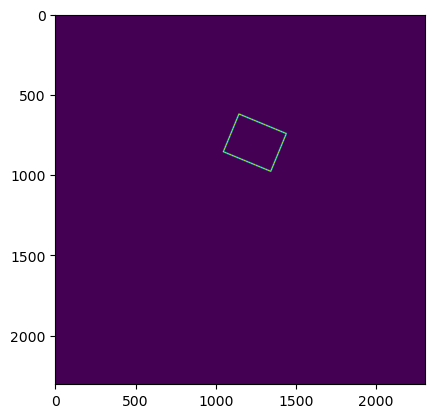

97 235


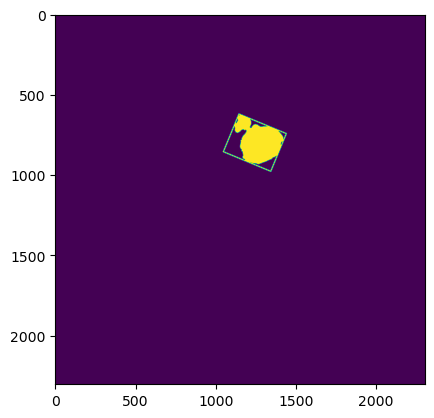

In [91]:
all_paths = glob.glob("E:/instru_projects/TimeLapses/u-wells/*/*.nd2") + glob.glob("F:/instru_projects/TimeLapses/u-wells/*/*.nd2")


In [99]:
total_ID = 0

for global_counter, video_path in enumerate(all_paths):

    video_name = os.path.split(video_path)[-1][:-4]
    results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
    pickel_path = os.path.join(results,"{}_detections.pkl".format(video_name))

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    with open('./dataStore/metalib.json', 'r') as f:
        own_meta = json.load(f)

    with open(pickel_path, 'rb') as f:
        total_dict = pickle.load(f)
        

    for counter, current_key in enumerate(total_dict.keys()):
        try:
            loc_ = int(current_key.split("_")[1])

            if loc_ in own_meta[day]['ignore']:
                print("ignoring")
                continue
        
            df_temp = pd.DataFrame()
            df_temp["x"] = np.array(total_dict[current_key]['x'])*own_meta[day]["m"]
            df_temp["y"] = np.array(total_dict[current_key]['y'])*own_meta[day]["m"]
            df_temp["z"] = np.array(total_dict[current_key]['z'])*own_meta[day]["z_step"]

            df_temp["t"] = np.arange(df_temp.shape[0])*own_meta[day]["dt"]+own_meta[day]["incubation_time"]
            df_temp["area"] = np.array(total_dict[current_key]['area'])*own_meta[day]["m"]
            df_temp["cell_label"] = own_meta[day]["cell"][loc_]
            df_temp["matrix"] = own_meta[day]["matrix"]
            df_temp["seeding_density"] = own_meta[day]["seeding_density"][loc_]
            df_temp["ID"] = total_ID
            total_ID += 1

            df_temp["MSD_tau"] = np.zeros(df_temp.shape[0])
            df_temp["t"] = np.zeros(df_temp.shape[0])

            img = (total_dict[current_key]['mask'][int(len(total_dict[current_key]['mask'][0])/2)][-1])
            cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
            
            thresh= img.astype("uint8") #np.stack((img,img,img), axis = -1) #thresh =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cnt,_ = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            rect = cv2.minAreaRect(cnt[0])
            box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
            box = np.int0(box)

            x_ = np.abs(box[0,0]-box[1,0])
            y_ = np.abs(box[0,1]-box[1,1])

            if x_ > y_ :
                major_axis = x_
                minor_axis = y_
            else :
                major_axis = y_
                minor_axis = x_

            circularity = minor_axis/major_axis
            df_temp["circularity"] = circularity
            
            for tau in range(1, df_temp.shape[0]):
                MSD = calc_MSD(df_temp, own_meta[day]["dt"], tau)
                df_temp.loc[tau,"MSD_tau"] = MSD
                df_temp.loc[tau,"t"] = tau*own_meta[day]["dt"]

            try:
                p, p_ = scipy.optimize.curve_fit(power_law, df_temp["t"], df_temp["MSD_tau"],  maxfev = 10000)
                df_temp["alpha"] = p[1]
                df_temp["ampltiude"] = p[0]
            except:
                print("failed", current_key)
                df_temp["alpha"] = 0#np.nan
                df_temp["ampltiude"] = 0#np.nan
        except:
            print("broken file", video_name, current_key)


        if counter == 0:
            df_meas = df_temp
        else:
            df_meas = pd.concat([df_meas,df_temp])

    if global_counter == 0:
        df = df_meas
    else:
        df = pd.concat([df, df_meas])

ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
broken file 240301_timelapses_collagen_3lines_48h_spheroidseeded loc_21_ch_BF
broken file 240302_timelapses_collagen_3lines_110h_spheroidseeded loc_1_ch_BF
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring
broken file 240304_timelapses_collagen_3lines_48h_spheroidseeded loc_19_ch_BF
ignoring
ignoring
ignoring
ignoring
ignoring
broken file 240311_timelapses_collagen_3lines_96h_spheroidseeded loc_5_ch_BF
ignoring
ignoring
ignoring
ignoring
ignoring
ignoring


In [100]:
df.loc[df["cell_label"] == "T", "cell_label"] = "MCF10AT"
df.loc[df["cell_label"] == "MCFA10A", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "MCFA10", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "DCIS", "cell_label"] = "DCIS.COM"


df = df.reset_index()

<Axes: xlabel='cell_label', ylabel='circularity'>

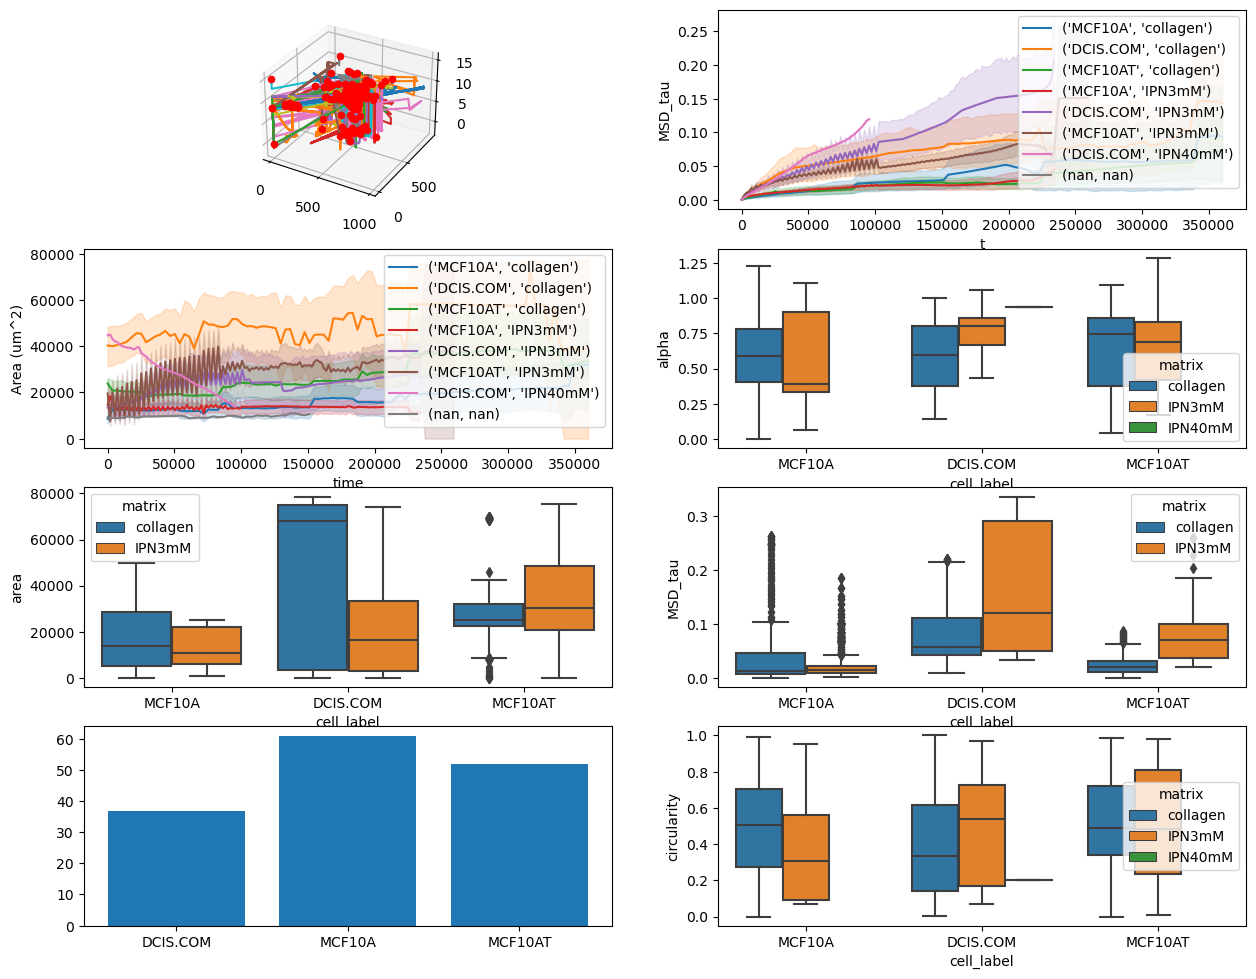

In [101]:

fig = plt.figure(figsize = (15,15))

ax = [ 
    fig.add_subplot(521, projection='3d'),
    fig.add_subplot(522),
    fig.add_subplot(523),
    fig.add_subplot(524),
    fig.add_subplot(525),
    fig.add_subplot(526),
    fig.add_subplot(527),
    fig.add_subplot(528)
]
for tags, data in df.groupby(["cell_label", "matrix", "ID"]):
    ax[0].plot3D(data["x"],  data["y"],data["z"])
    ax[0].scatter(data["x"].values[0],  data["y"].values[0],(data["z"]).values[0], label = False, color ="red")
    
    #ax[1].scatter(data["t"], data["MSD_tau"])
    x_data = np.arange(0,data["t"].values[-1], 10)
    y_data = power_law(x_data, data["ampltiude"].values[0], data["alpha"].values[0])
    #ax[1].plot(x_data, y_data, color = "red")


sns.lineplot(x = "t", y = "MSD_tau", hue =df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[1])

#ax[1].set_xlabel("time lag (s)")
#ax[1].set_ylabel("MSD")


sns.lineplot(x = "t", y = "area", hue = df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[2])
ax[2].set_xlabel("time")
ax[2].set_ylabel("Area (um^2)")

sns.boxplot(x = "cell_label", y= "alpha", data = df, hue = "matrix" ,ax = ax[3], showfliers = False)

mm = df.groupby(["cell_label", "matrix"]).mean().reset_index()
mm = df[(df["t"].values > 150000) & (df["t"].values < 250000)].reset_index()

sns.boxplot(x = "cell_label", y = "area", data = mm, hue = "matrix", ax = ax[4])
sns.boxplot(x = "cell_label", y = "MSD_tau", data = mm, hue = "matrix", ax = ax[5])


mm = df.groupby(["cell_label", "ID"]).mean().reset_index()
values, counts = np.unique(np.array(mm["cell_label"].values.astype(str)), return_counts=True)
ax[6].bar(values, counts)

sns.boxplot(x = "cell_label", y = "circularity", data = df, hue = "matrix", ax = ax[7])

In [102]:
df.to_csv("./dataStore/tracked_all_circ.csv")

In [81]:
df = pd.read_csv("./dataStore/tracked_all.csv")

array(['MCF10A', 'MCF10A', 'MCF10A', ..., 'MCF10AT', 'MCF10AT', 'MCF10AT'],
      dtype=object)